In [1]:
import numpy as np
import xmltodict
import matplotlib.pyplot as plt

# loading helper function
def spin_matrices_from_xml(path_to_projection_matrices):
    assert str(path_to_projection_matrices).endswith('.xml')
    with open(path_to_projection_matrices) as fd:
        matrices = xmltodict.parse(fd.read())['hdr']['ElementList']['PROJECTION_MATRICES']
        projmat = [np.array(matrices[key].split(" "), order='C').reshape((3, 4)) for key in matrices.keys()]
    return np.asarray(projmat).astype(np.float32)

## Camera view coordinate alignment

Suppose we have a set of points $X = \{x_i \in \mathbb{R}^{3} \}$ in a world coordinate system. We can create an image p given the projection matrix $P \in \mathbb{R}^{3 \times 4}$ by mapping each point onto the 2D image plane using $u_i = P x_i$. Note, that in order to express this non-affine transform compactly, we make use of homogenous coordinates. A 3-dimensional point is thus represented as a 4-vector in so called projective space $x_i \in \mathbb{P}^{3+} = (x, y, z, 1)^{\top}$.

### The projection matrix $P$

The view transform is compactly represented by the projection matrix $P$. However, we can decompose it into its constituent components K, R and t. Here, the camera matrix $K \in \mathbb{R}^{3 \times 3}$ encodes the viewing parameters such as source-detector-distance, the rotation matrix $R \in \mathbb{R}^{3 \times 3}$ encodes the viewing direction and t controls the translation of the world coordinates prior to projection.

$$ P = K [R|t] = K [R | - R^{\top} C ] = [KR|Kt] = [M | p3 ] $$

Per convention, the default viewing direction of our imaginary camera is in positive z-direction. The rotation matrix R rotates all points in the world coordinate system, such that the desired 3D viewing direction is aligned with the z-axis. Then, the z-axis is omitted, which is the actual 3D-2D dimensionality reduction / projection step. Finally, the homogenous 2D projective coordinates are transformed with the camera matrix to account for perspective changes.

We can decompose a projection matrix into its sub-components by making a few observations. The left $3 \times 3$ sub-matrix M is the product of K and R. As the Camera Matrix K must be an upper triangle matrix, and R must be an orthogonal matrix (all rotation matrices are), we can use a RQ decomposition (the lesser known brother to QR decompositions see [here](https://en.wikipedia.org/wiki/QR_decomposition#Relation_to_RQ_decomposition) for more info). When we know the camera matrix, we can recover t from the rightmost column vector $p_3$ either by multiplying with the inverse or using back substitution of the triangular equation system $p_3 = Kt$.

Lets look at the code:


In [2]:
def RQfactorize(A):
    A_flip = np.flip(A, axis=0).T  # shape 4x3
    Q_flip, R_flip = np.linalg.qr(A_flip)  # shapes 4x4, 4x3

    # make camera matrix look into positive direction!
    for i in range(3):
        if R_flip[i, i] < 0:
            R_flip[i, :] *= -1
            Q_flip[:, i] *= -1
        assert R_flip[i, i] > 0

    R = np.flip(np.flip(R_flip.T, axis=1), axis=0)
    Q = np.flip(Q_flip.T, axis=0)
    return R, Q


def decompose(P, scaleIntrinsic=False):
    # 1. Split P in two components --> P = [M|p3] = [KR|Kt] = [KR'|-R'C] where C is the source point
    M, p3 = P[:3, :3].copy(), P[:, 3].copy()

    # 2. RQ - factorisation of m. K is upper triangle matrix, R is orthogonal
    K, R = RQfactorize(M)

    # 3. calculate translation by back substitution. p3 is Kt
    t = np.zeros(3)
    t[2] = p3[2] / K[2, 2]
    t[1] = (p3[1] - K[1, 2] * t[2]) / K[1, 1]
    t[0] = (p3[0] - K[0, 1] * t[1] - K[0, 2] * t[2]) / K[0, 0]

    # 5. Optionally scale the camera intrinsic
    if scaleIntrinsic:
        K *= (1 / K[2, 2])

    return K, R, t

Lets load some projection matrices and plot source points for verification. As detailed above, the source position can be recovered from the translation and rotation through $C = - R^{\top}t$. Furthermore, we also plot the central ray direction in world coordinates, which can be directly obtained as the last row-vector in $M$.

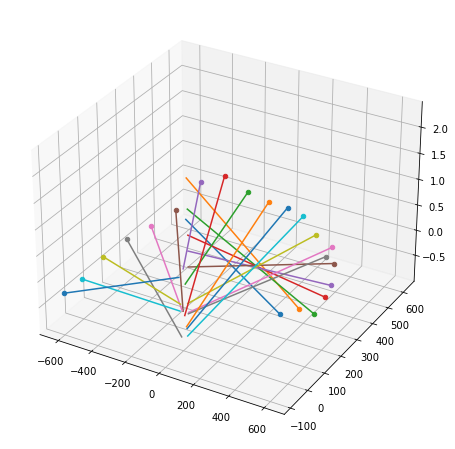

In [3]:
# loads 20 real matrices over the angular range from 0-200 degrees
matrices = spin_matrices_from_xml('SpinProjMatrix20.xml')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
for i, P in enumerate(matrices):
    K, R, t = decompose(P)
    C = -R.T @ t
    ax.scatter(*C, label=f'C{i}')
    central_ray_direction = P[2, :3] / np.linalg.norm(P[2, :3])
    ax.plot(*np.asarray([C, C + central_ray_direction * 600]).T)
plt.show()

Note, that the values along the z-axis are not completely 0 as we are working with real projection matrices and they are calibrated for one measured trajectory. Apart from this, our decomposition looks sensible.

## View aligned coordinate systems

Lets only have a look at two views $P_0$, and $P_{90}$. To start, lets generate a cube-shaped point cloud and obtain the projection images thereof from both views.

In [4]:
def rasterize_view(_P, _points3d):
    view =  np.zeros((976, 976))
    _points2d = _P @ np.pad(_points3d, ((0, 1), (0, 0)), constant_values=1)
    pos_u, counts = np.unique(_points2d.astype(int), axis=1, return_counts=True)
    view[pos_u[1], pos_u[0]] = counts
    return view


(3, 2000)


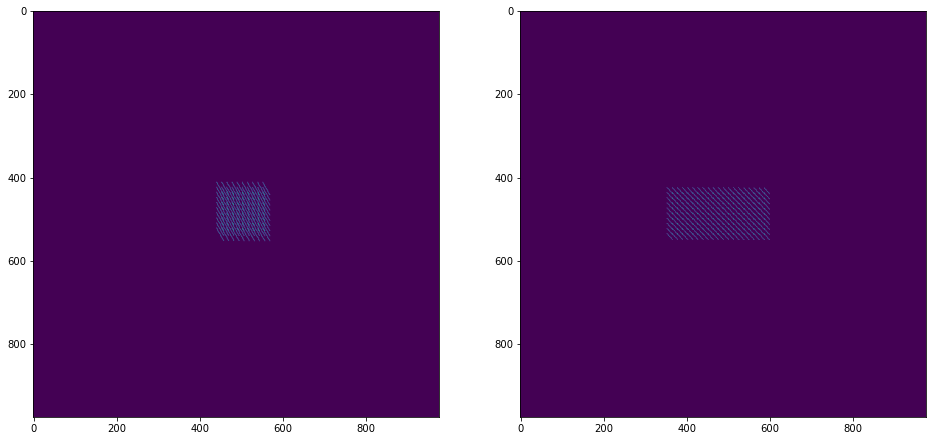

In [5]:
# select projection matrices at roughly 0 and 90 degrees
P0, P90 = matrices[1], matrices[10]

# sample points within a cube centered at the origin with one side being double as long as the others
cube = np.mgrid[-20:20:2, -10:10:2, -10:10:2].reshape((3, -1))
print(cube.shape)

# instantiate two detector images
view0 = rasterize_view(P0, cube)
view90 = rasterize_view(P90, cube)

# plot images
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(view0)
plt.subplot(122); plt.imshow(view90)
plt.show()

Now, we want to find a mapping, such that the projection along P0 looks similar to the projection along P90. Basically, we want to find a transform $A \in \mathbb{R}^{4 \times 4}$ such that $P_0 A x_i = P_{90} x_i \forall i$. As the camera matrix can be assumed identical in both projection matrices, the sole difference lies in $R$ and $t$. So, we want to find a transform, that satisfies

$$[R_0|t_0]A=[R_{90}|t_{90}]$$

Solving for A yields

$$A=[R_0|t_0]^{-1}[R_{90}|t_{90}]$$


In [6]:
def compose4x4(_R, _t):
    out = np.eye(4)
    out[:3, :3] = _R
    out[:3, 3] = _t
    return out

_, R0, t0 = decompose(P0)
_, R90, t90 = decompose(P90)
A = np.linalg.inv(compose4x4(R0, t0)) @ compose4x4(R90, t90)
print(A.shape)

(4, 4)


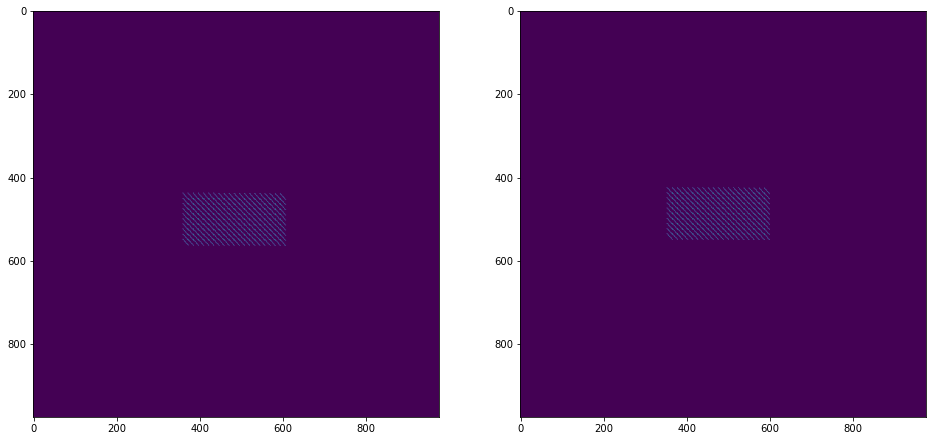

In [7]:
# instantiate two detector images
view0 = rasterize_view(P0 @ A, cube)
view90 = rasterize_view(P90, cube)

# plot images
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(view0)
plt.subplot(122); plt.imshow(view90)
plt.show()

### How to implement this as label normalization

This looks promising. The transform A allows us to re-use the projection $P_0$ to generate the view $P_{90}$. In the example above, we added $A$ to $P_0$, but because of commutativity we can just as well transform the points prior to projection.

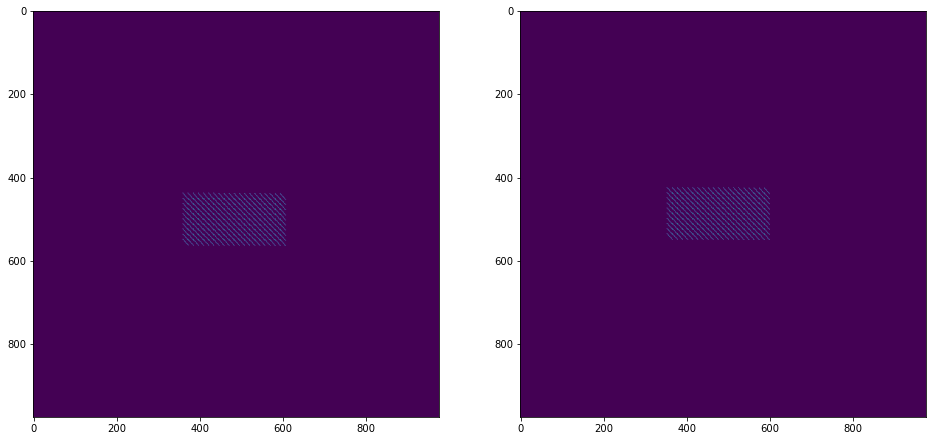

In [8]:
# preprocess points
cube_adapted = A @ np.pad(cube, ((0, 1), (0, 0)), constant_values=1)
cube_adapted = cube_adapted[:3] / cube_adapted[3]  # de-homogenize

# compute two detector images
view0 = rasterize_view(P0, cube_adapted)
view90 = rasterize_view(P90, cube)

# plot images
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(view0)
plt.subplot(122); plt.imshow(view90)
plt.show()

In our model training, we can preprocess all ellipsoid parameters using this transform such that they align with $P_0$. Then, the relative ellipsoid parameters are relative to the viewing direction and source position of $P_0$. Intuitively, $A$ simply rotates and moves the 3D objects prior to projection, such that they align with the extrinsics of $P_0$. During training, we can therefore re-use the same projection matrices $P_0, P_{90}$ if we adapt the 3D labels accordingly.

#### Example

Suppose we have a full-circle scan of $N=360$ images $p_i, i \in 1 ... N$, corresponding projection matrices $P_i$ and an ellipsoid given as centroid $\mu$ and covariance $\Sigma$. We can now resample this scan into orthogonal pairs $(p_{i}, p_{i+90})$. To be able to use the same projection matrices for all of these view-pairs, we calculate a transform from $P_i$ relative to $P_0$ and align the ellipsoid accordingly. E.g. The transform for view pair $i=20$ would be

$$A_{0, 20}=[R_0|t_0]^{-1}[R_{20}|t_{20}]$$.

The ellipsoid parameters need to be adapted like this

$$ \mu' = A_{0, 20}\mu, \Sigma' = A_{0, 20} \Sigma $$

By normalizing the 3D ground truth relative to the 0 degree view, we can use the same projection matrix pair $(P_0, P_{90})$ for all samples of this scan. The model will learn the implicit mapping from these two views into the world coordinate system.
